In [1]:
import os
import warnings
warnings.simplefilter('ignore')
from cnmf import cNMF
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplscience

In [2]:
adata = sc.read_h5ad('../output/9_annotated_subcluster_embedding_tumor_nmf_added.h5ad')
adata

AnnData object with n_obs × n_vars = 13249 × 12431
    obs: 'sample_id', 'sample_info', 'age', 'sex', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'cell_type', 'grade', 'GFP', 'leiden_res1', 'wb_anno', 'wb_conf_score', 'cellid_prediction', 'leiden_res2', 'new_cell_type', 'old_cell_type', 'leiden', 'predicted_labels', 'conf_score', 'each_cell_type', '_scvi_batch', '_scvi_labels', 'NMF_Module_1', 'NMF_Module_2', 'NMF_Module_3', 'NMF_Module_4', 'NMF_Module_5', 'NMF_Module_6'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'each_cell_type_colors', 'grade_colors', 'neighbors', 'sample_id_colors', 'sample_info_colors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 

In [3]:
cnmf_obj = cNMF(output_dir = '../output/tumor_only/cNMF', name = 'subcluster')
usage_norm, gep_scores, gep_tpm, topgenes = cnmf_obj.load_results(K=6, density_threshold=0.5)
usage_norm.columns = [f'NMF_Module_{i}' for i in usage_norm.columns]

# 1. Celltypist

In [ ]:
bdata = sc.AnnData(gep_tpm)
bdata.T.write('../output/nmf_for_ct_tumor.h5ad')

In [2]:
import os
import warnings
warnings.simplefilter('ignore')
import celltypist
import scanpy as sc
import numpy as np

In [3]:
adata = sc.read_h5ad('../output/nmf_for_ct_tumor.h5ad')

In [5]:
np.sum(adata.X, axis = 1)

array([ 983434.05450863, 1003635.50218979, 1071729.86538846,
        981144.72016384,  983836.75200669,  990144.48690096])

In [6]:
scale_factor = 10000 / adata.X.sum(axis=1).reshape(-1, 1)
adata.X = adata.X * scale_factor
adata.X = np.log1p(adata.X)

In [7]:
wb_model = celltypist.models.Model.load(model = 'Mouse_Whole_Brain.pkl')

bdata = adata.copy()
# predictions = celltypist.annotate(bdata, model = wb_model, mode = 'prob match', p_thres=0.5)
predictions = celltypist.annotate(bdata, model = wb_model, majority_voting=True)
predictions_adata = predictions.to_adata()
adata.obs['wb_anno'] = predictions_adata.obs['predicted_labels']
adata.obs['wb_conf_score'] = predictions_adata.obs['conf_score']

del predictions_adata
del bdata

🔬 Input data has 6 cells and 12431 genes
🔗 Matching reference genes in the model
🧬 2972 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
⚠️ Warning: the input number of cells (6) is too few to conduct proper over-clustering; no majority voting is performed


In [8]:
wb_model = celltypist.models.Model.load(model = 'Developing_Mouse_Brain.pkl')

bdata = adata.copy()
# predictions = celltypist.annotate(bdata, model = wb_model, mode = 'prob match', p_thres=0.5)
predictions = celltypist.annotate(bdata, model = wb_model, majority_voting=True)
predictions_adata = predictions.to_adata()
adata.obs['dev_wb_anno'] = predictions_adata.obs['predicted_labels']
adata.obs['dev_wb_conf_score'] = predictions_adata.obs['conf_score']

del predictions_adata
del bdata


🔬 Input data has 6 cells and 12431 genes
🔗 Matching reference genes in the model
🧬 4829 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
⚠️ Warning: the input number of cells (6) is too few to conduct proper over-clustering; no majority voting is performed


# 2. SingleR

In [12]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy
# R integration
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
anndata2ri.activate()
ro.pandas2ri.activate()
%load_ext rpy2.ipython

cffi mode is CFFI_MODE.ANY
R home found: /Library/Frameworks/R.framework/Resources
R library path: 
LD_LIBRARY_PATH: 
Default options to initialize R: rpy2, --quiet, --no-save
: Successfullly loaded R Profile
R is already initialized. No need to initialize.


In [14]:
bdata = sc.read_h5ad('../output/nmf_for_ct_tumor.h5ad')
bdata

AnnData object with n_obs × n_vars = 6 × 12431

In [15]:
%%R
library(SingleR)
library(celldex)

ref <- celldex::MouseRNAseqData()

Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse, colCounts, colCummaxs, colCummins,
    colCumprods, colCumsums, colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs, colMads, colMaxs,
    colMeans2, colMedians, colMins, colOrderStats, colProds, colQuantiles, colRanges, colRanks, colSdDiffs,
    colSds, colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads, colWeightedMeans,
    colWeightedMedians, colWeightedSds, colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods, rowCumsums, rowDiffs, rowIQRDiffs,
    rowIQRs, rowLogSumExps, rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins, rowOrderStats,
    rowProds, rowQuantiles, rowRanges, rowRanks, rowSdDif

In [16]:
%%R -i bdata -o out
mat <- assay(bdata)
pred <- SingleR(test = mat, ref = ref, labels = ref$label.fine)
out <- data.frame(pred$labels)

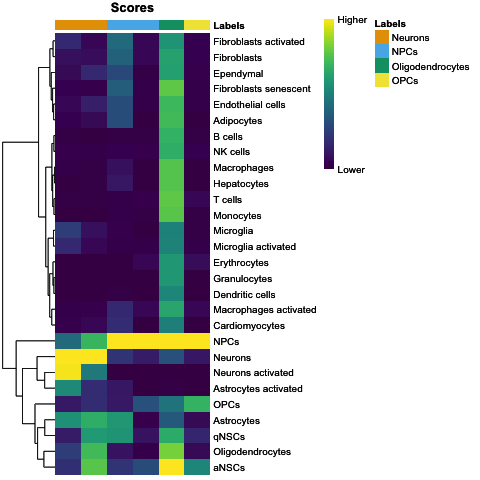

In [17]:
%%R
plotScoreHeatmap(pred)

In [18]:
adata.obs['singleR_anno'] = out['pred.labels']
adata.obs

,wb_anno,wb_conf_score,dev_wb_anno,dev_wb_conf_score,singleR_anno
1,326 OPC NN,0.999613,Oligodendrocyte: Oligodendrocyte precursor cell,1.000000,Neurons
2,326 OPC NN,0.999982,Oligodendrocyte: Oligodendrocyte precursor cell,1.000000,Neurons
3,326 OPC NN,0.999266,Oligodendrocyte: Oligodendrocyte precursor cell,0.999941,Oligodendrocytes
4,330 VLMC NN,0.004256,Vascular: Vascular smooth muscle,1.000000,NPCs
5,045 OB-STR-CTX Inh IMN,0.936748,Oligodendrocyte: Oligodendrocyte precursor cell,1.000000,NPCs
6,045 OB-STR-CTX Inh IMN,0.994075,Oligodendrocyte: Oligodendrocyte precursor cell,1.000000,OPCs


In [21]:
adata.obs[['wb_anno', 'dev_wb_anno','singleR_anno']].to_csv('../output/tumor_nmf_ref.csv')
adata.obs[['wb_anno', 'dev_wb_anno','singleR_anno']]

,wb_anno,dev_wb_anno,singleR_anno
1,326 OPC NN,Oligodendrocyte: Oligodendrocyte precursor cell,Neurons
2,326 OPC NN,Oligodendrocyte: Oligodendrocyte precursor cell,Neurons
3,326 OPC NN,Oligodendrocyte: Oligodendrocyte precursor cell,Oligodendrocytes
4,330 VLMC NN,Vascular: Vascular smooth muscle,NPCs
5,045 OB-STR-CTX Inh IMN,Oligodendrocyte: Oligodendrocyte precursor cell,NPCs
6,045 OB-STR-CTX Inh IMN,Oligodendrocyte: Oligodendrocyte precursor cell,OPCs


# 3. PanglaoDB

In [53]:
import warnings
warnings.simplefilter('ignore')
import scanpy as sc
import decoupler as dc
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
pg_markers = dc.get_resource('PanglaoDB')
pg_markers = pg_markers[pg_markers['mouse'] & pg_markers['canonical_marker'] & (pg_markers['mouse_sensitivity'] > 0.5)]
pg_markers = pg_markers[~pg_markers.duplicated(['cell_type', 'genesymbol'])]

In [32]:
pg_markers['genesymbol'] = pg_markers['genesymbol'].str.capitalize()
pg_markers

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
1,Ctrb1,True,Acinar cells,Endoderm,True,1.000000,0.000629,True,0.957143,0.015920,9606,Pancreas,0.017
7,Klk1,True,Plasmacytoid dendritic cells,Mesoderm,True,0.000000,0.008202,True,1.000000,0.012914,9606,Immune system,0.013
23,Cela2a,True,Acinar cells,Endoderm,True,0.333333,0.000000,True,0.628571,0.002900,9606,Pancreas,0.005
26,Cela1,True,Acinar cells,Endoderm,True,0.000000,0.000000,True,0.814286,0.017467,9606,Pancreas,0.017
30,Amy2b,True,Acinar cells,Endoderm,True,0.083333,0.000000,True,0.528571,0.001482,9606,Pancreas,0.003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8342,Col23a1,True,Tanycytes,Ectoderm,True,0.000000,0.000000,True,0.952381,0.004755,9606,Brain,0.005
8384,Avil,True,Tuft cells,Endoderm,True,0.000000,0.000313,True,1.000000,0.005908,9606,GI tract,0.005
8418,Cdhr2,True,Tuft cells,Endoderm,True,0.000000,0.016604,True,0.769231,0.012137,9606,GI tract,0.013
8419,Espn,True,Tuft cells,Endoderm,True,0.000000,0.015038,True,1.000000,0.017917,9606,GI tract,0.017


In [23]:
bdata = sc.read_h5ad('../output/nmf_for_ct_tumor.h5ad')
bdata

AnnData object with n_obs × n_vars = 6 × 12431

In [34]:
dc.run_ora(mat = bdata, net = pg_markers, source = "cell_type", target = "genesymbol", min_n = 3, use_raw = False)
acts = dc.get_acts(bdata, obsm_key='ora_estimate')
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

<Axes: ylabel='source'>

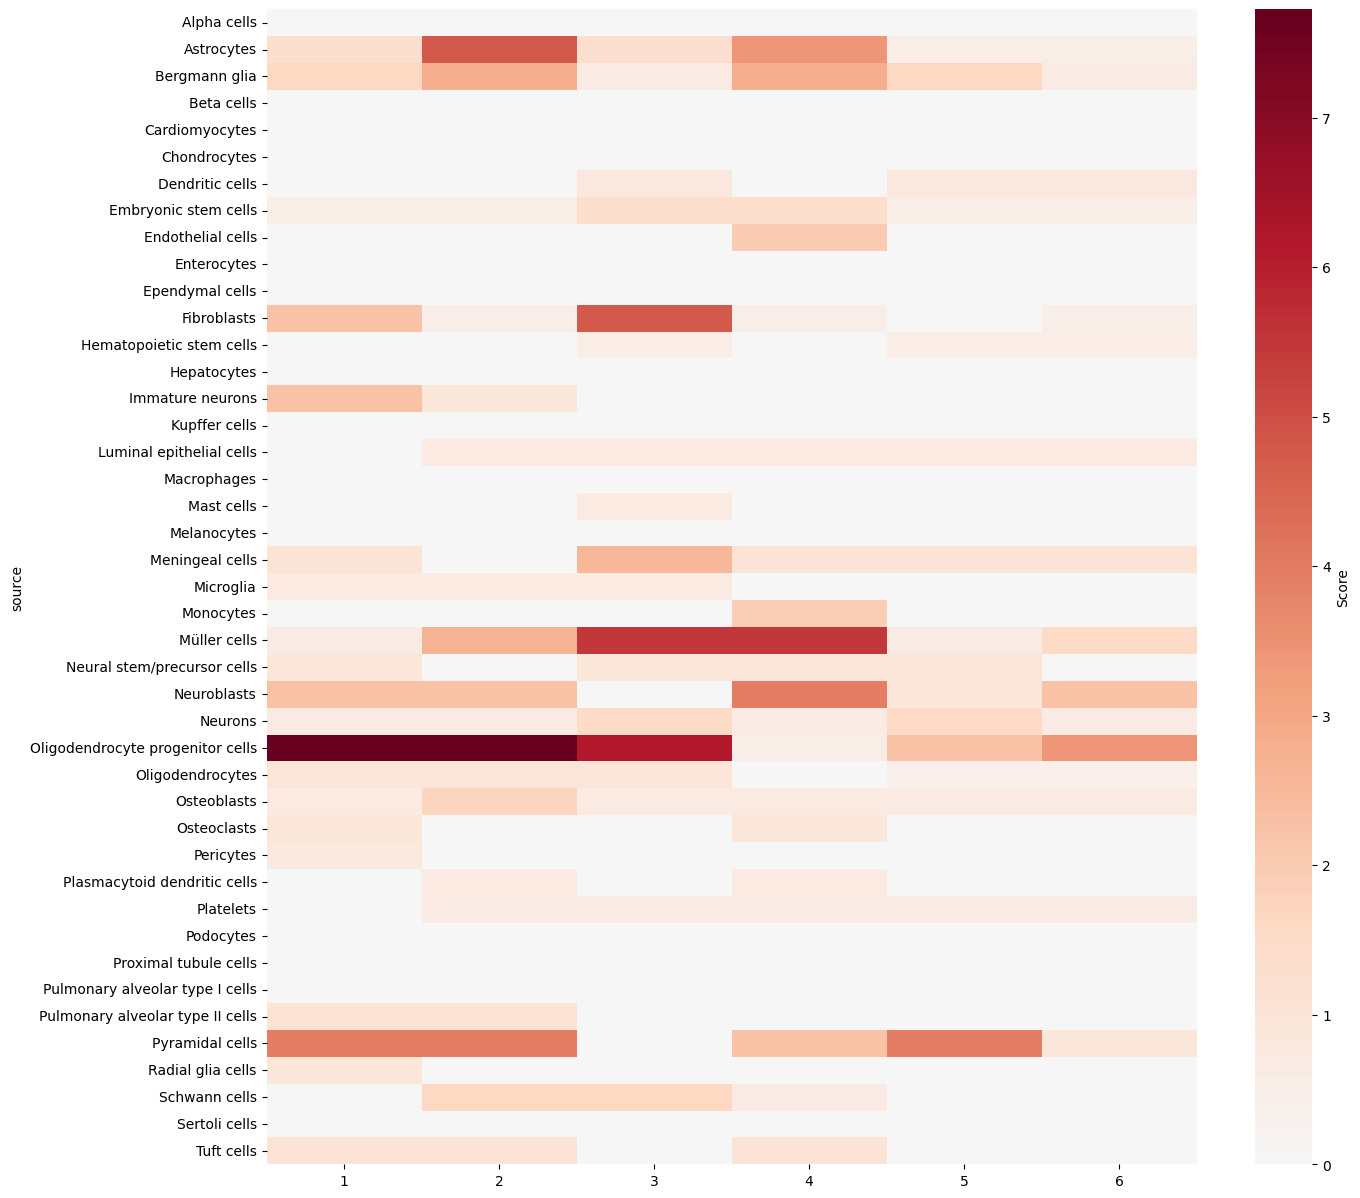

In [56]:
plt.figure(figsize=(15, 15))
sns.heatmap(acts.obsm['ora_estimate'].T, 
            cmap='RdBu_r',  # Red-Blue diverging colormap
            center=0,       # Center colormap at 0
            fmt='.2f',      # Round to 2 decimal places
            cbar_kws={'label': 'Score'},
            xticklabels=True,
            yticklabels=True)